In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from random import sample
%matplotlib inline

DIR = 'data'

In [2]:
# Reading names
words = open(f'{DIR}/names.txt').read().splitlines()
words[:5]

['ieretha', 'bruni', 'bran', 'rachoisa', 'marry']

In [3]:
symbols = sorted(list(set(''.join(words))))
num_of_symbols = 1 + len(symbols)   # adding '.' to the vocab
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [4]:
stoi = {ch: i + 1 for i, ch in enumerate(symbols)}
stoi['.'] = 0

itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'y', 0: '.'}


### Building dataset
_block_size_: context length (how many previous characters are considered in the prediction) 

_X_: neural net inputs 

_Y_: neural net input labels

In [5]:
block_size = 3
X, Y = [], []

In [6]:
def train_test_split(X: torch.tensor, Y: torch.tensor, p: float):
    train_size = int(p * X.shape[0])

    idxs = set([i for i in range(X.shape[0])])
    train_idxs = set(sample(idxs, k=train_size))
    test_idxs = idxs - train_idxs

    train_idxs, test_idxs = list(train_idxs), list(test_idxs)
    return X[train_idxs], Y[train_idxs], X[test_idxs], Y[test_idxs]

In [7]:
for name in words:
    context = [0] * block_size
    for ch in name + '.':
        idx = stoi[ch]
        X.append(context)
        Y.append(idx)

        # context update
        context = context[1:] + [idx] 

X, Y = torch.tensor(X), torch.tensor(Y)

In [8]:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, 0.8)

/tmp/ipykernel_835/1926032739.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_idxs = set(sample(idxs, k=train_size))


### Parameters

In [9]:
# Hyperparameters
emb_dimensions = 10
num_of_neurons = 100 

minibatch_size = 64
num_of_epochs = 100000

## NN parameters
hl_input_length = block_size * emb_dimensions
C = torch.randn((num_of_symbols, emb_dimensions))
W1 = torch.randn((hl_input_length, num_of_neurons)) * (5/3) / hl_input_length**0.5
W2 = torch.randn((num_of_neurons, num_of_symbols)) * 0.01
b2 = torch.zeros(num_of_symbols) 
bn_gain = torch.ones((1, num_of_neurons))
bn_bias = torch.zeros((1, num_of_neurons))

bn_mean_running = torch.zeros((1, num_of_neurons))
bn_std_running = torch.ones((1, num_of_neurons))

In [10]:
parameters = [C, W1, W2, b2, bn_bias, bn_gain]
for p in parameters:
    p.requires_grad = True

### Model Training

In [32]:
lre = torch.linspace(-3, 0, num_of_epochs)
lrs = 10**lre

In [11]:
# Once the learning rates were evaluated, we choose a good one
lr = 10**-1

In [12]:
losses = []

In [13]:
# Stochastic Gradient Descent
for i in range(num_of_epochs):
    idx = torch.randint(0, X_train.shape[0], (minibatch_size,))

    """ Forward pass """
    emb = C[X_train[idx]]
    emb_cat = emb.view(-1, hl_input_length)                
    h_preac = emb_cat @ W1                                              # hidden layer preactivation
    bn_meani = h_preac.mean(0, keepdim=True)                            
    bn_stdi =  h_preac.std(0, keepdim=True)                                 
    h_preac = bn_gain * (h_preac - bn_meani) / bn_stdi  + bn_bias       # batch norm
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_meani
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_stdi

    h = torch.tanh(h_preac)                                             # hidden layer
    logits = h @ W2 + b2                                                # output layer
    loss = F.cross_entropy(logits, Y_train[idx])                        # loss
    losses.append(loss.log10().item())

    if not i % 10000:
        print(f"epoch {i}, loss={loss.item()}")

    """ Backward pass """
    for p in parameters:
        p.grad = None
    loss.backward()

    """ Update """
    lr = lr/2 if i == num_of_epochs//2 else lr 
    for p in parameters:
        p.data += -lr * p.grad

epoch 0, loss=3.1831371784210205
epoch 10000, loss=1.5443618297576904
epoch 20000, loss=1.6444400548934937
epoch 30000, loss=1.602728009223938
epoch 40000, loss=1.4292651414871216
epoch 50000, loss=1.4054670333862305
epoch 60000, loss=1.5445952415466309
epoch 70000, loss=1.4850598573684692
epoch 80000, loss=1.4801595211029053
epoch 90000, loss=1.2903544902801514


### Searching for a good learning rate
Based on the first 1000 epochs, the learning rates used generated the following losses

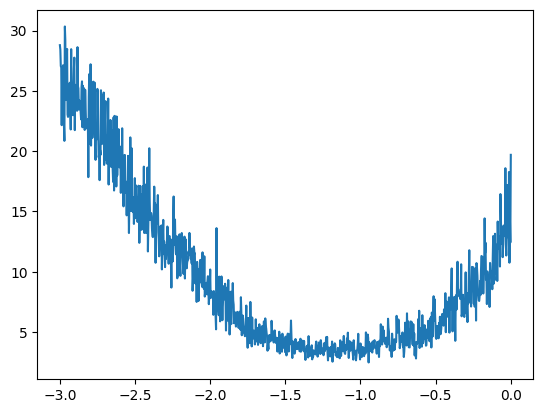

In [ ]:
plt.plot(lre, losses)

We can see that around $lr=-1$, the loss was at its lowest. Therefore, that value will be used for the training

### Loss curve

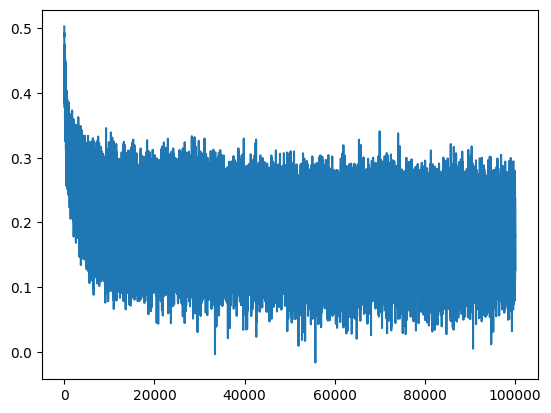

In [14]:
plt.plot(torch.arange(0, num_of_epochs), losses)

### Test loss

In [16]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preac = emb_cat @ W1
    h_preac = bn_gain * (h_preac - bn_mean_running) / bn_std_running + bn_bias   
    h = torch.tanh(h_preac)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split=}: {loss.item()}")

split_loss('train')
split_loss('test')

split='train': 1.483785629272461
split='test': 1.4906799793243408


### Sampling from the model

In [17]:
samples = []
for _ in range(10):
    idx, out = 0, ""
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        emb_cat = emb.view(emb.shape[0], -1)
        h_preac = emb_cat @ W1
        h_preac = bn_gain * (h_preac - bn_mean_running) / bn_std_running + bn_bias   
        h = torch.tanh(h_preac)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [idx]
        if idx == 0:
            break

        out += itos[idx]
    samples.append(out)

print(samples)

['sival', 'anois', 'thardel', 'temina', 'dalindinn', 'kolwolla', 'aulen', 'geretto', 'domunda', 'arnell']
